In [579]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

In [580]:
plt.style.use("ggplot")

### 1. Data understanding and cleaning

In [581]:
data = pd.read_csv("train (1).csv")

In [582]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [583]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


#### Checking for null values

In [584]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_3g_6                   74.902499
count_rech_2g_6             74.902499
night_pck_user_6            74.902499
arpu_2g_6                   74.902499
date_of_last_rech_data_6    74.902499
                              ...    
last_day_rch_amt_8           0.000000
vol_2g_mb_6                  0.000000
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
churn_probability            0.000000
Length: 172, dtype: float64

Let's drop all the features having more than 70% of null values

In [585]:
data.dropna(thresh=len(data.index) * 0.7, axis=1, inplace=True)

In [586]:
data.shape

(69999, 142)

#### Dropping redundant feature

##### Low variance feature

In [587]:
redundant_cols = []
for col in data.columns:
    counts = data[col].value_counts()
    count_max = counts.iloc[0]
    if count_max / len(data) * 100 > 95:
        redundant_cols.append(col)
redundant_cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'og_others_7',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [588]:
data.loc_og_t2o_mou.value_counts()

0.0    69297
Name: loc_og_t2o_mou, dtype: int64

In [589]:
data.circle_id.value_counts()

109    69999
Name: circle_id, dtype: int64

These values have very low variance and it does not contain any information, so lets drop these features

In [590]:
data.drop(redundant_cols, axis=1, inplace=True)

##### Dropping id

In [591]:
data.drop("id", axis=1, inplace=True)

In [592]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(100), int64(23), object(3)
memory usage: 67.3+ MB


#### Data transformation

##### Lets have a look at the object types

In [593]:
data.select_dtypes('object').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

These are all datetime fields.

In [594]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.year.value_counts()

2014.0    68898
Name: date_of_last_rech_6, dtype: int64

In [595]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.month.value_counts()

6.0    68898
Name: date_of_last_rech_6, dtype: int64

For each of these fields month and year are the same, so we can remove them and just keep the day

In [596]:
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [597]:
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [598]:
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [599]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(103), int64(23)
memory usage: 67.3 MB


##### Lets no replace all null values with median

In [600]:
data.fillna(data.median(), inplace=True)

In [601]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_6               0.0
total_ic_mou_6       0.0
total_rech_num_7     0.0
total_rech_num_6     0.0
ic_others_8          0.0
                    ... 
std_og_t2f_mou_7     0.0
std_og_t2f_mou_6     0.0
std_og_t2m_mou_8     0.0
std_og_t2m_mou_7     0.0
churn_probability    0.0
Length: 126, dtype: float64

#### Feature engineering

##### Adding column of average revenue per user for all three months

In [602]:
data["arpu"] = (data["arpu_6"] + data["arpu_7"] + data["arpu_8"] ) / 3

In [603]:
data["arpu"].describe([0.9, 0.95, 0.97, 0.98])

count    69999.000000
mean       280.059701
std        310.243414
min         13.426667
50%        199.662667
90%        584.719133
95%        773.942000
97%        920.071487
98%       1050.861547
max      32140.182000
Name: arpu, dtype: float64

We can see that there are some really high value customers

##### Adding column of total recharge done by customer for all three months

In [604]:
data["total_rech_amt"] = data["total_rech_amt_6"] + data["total_rech_amt_7"] + data["total_rech_amt_8"]

In [605]:
data["total_rech_amt"].describe([0.9, 0.95, 0.97, 0.98])

count     69999.000000
mean        974.362505
std        1106.099526
min           0.000000
50%         692.000000
90%        2052.000000
95%        2724.100000
97%        3238.000000
98%        3708.040000
max      120845.000000
Name: total_rech_amt, dtype: float64

##### Adding total data usags

In [606]:
data["total_vol_2g_3g"] = data["vol_2g_mb_6"] + data["vol_2g_mb_7"] + data["vol_2g_mb_8"] + data["vol_3g_mb_6"] + data["vol_3g_mb_7"] + data["vol_3g_mb_8"]

##### Adding total min of usage

In [607]:
data["total_mou"] = data["onnet_mou_6"] + data["onnet_mou_7"] + data["onnet_mou_8"] + data["offnet_mou_6"] + data["offnet_mou_7"] + data["offnet_mou_8"]

##### Create High Value Customer data frame based on above two columns

In [608]:
data_hvc = data[ 
    ( ( data["arpu"] >= data["arpu"].quantile(0.70) ) & ( data["arpu"] < data["arpu"].quantile(0.999) )) | 
    ( ( data["total_rech_amt"] >= data["total_rech_amt"].quantile(0.70) ) & 
     ( data["total_rech_amt"] < data["total_rech_amt"].quantile(0.999) ) ) ]

In [609]:
data_hvc.shape

(21875, 130)

### 2. EDA

In [610]:
data_hvc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21875 entries, 12 to 69996
Columns: 130 entries, arpu_6 to total_mou
dtypes: float64(106), int64(24)
memory usage: 21.9 MB


##### Target variable distribution

In [611]:
data_hvc.churn_probability.value_counts()

0    20465
1     1410
Name: churn_probability, dtype: int64

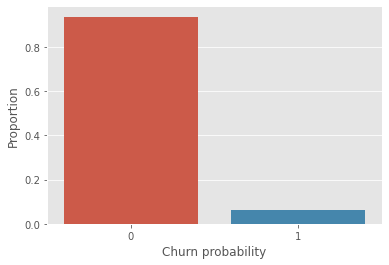

In [612]:
sns.barplot(data=data_hvc["churn_probability"].value_counts(normalize=True).reset_index(),
            x="index", y="churn_probability")
plt.xlabel("Churn probability")
plt.ylabel("Proportion")
plt.show()

The distribution of churn and not churn is clearly not equally distributed

##### Relationship of target variable and total_rech_amt

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt'>

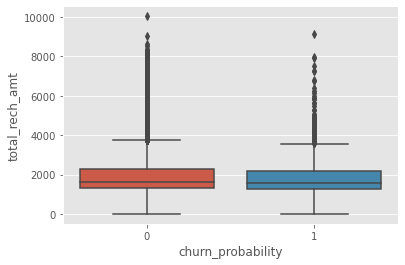

In [613]:
sns.boxplot(data=data_hvc, x="churn_probability", y="total_rech_amt")

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_8'>

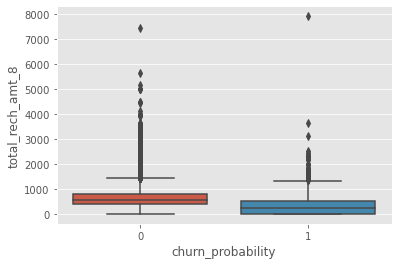

In [614]:
sns.boxplot(data=data_hvc, x="churn_probability", y="total_rech_amt_8")

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_7'>

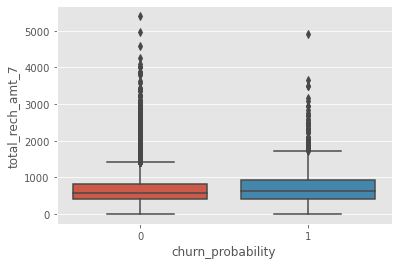

In [615]:
sns.boxplot(data=data_hvc, x="churn_probability", y="total_rech_amt_7")

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_6'>

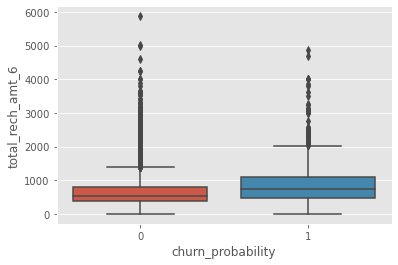

In [616]:
sns.boxplot(data=data_hvc, x="churn_probability", y="total_rech_amt_6")

We can see from here that if customer is recharging less consecutively from june to july to august he/she is more likely to churn

##### Relationship of target variable and arpu

<AxesSubplot:xlabel='churn_probability', ylabel='arpu'>

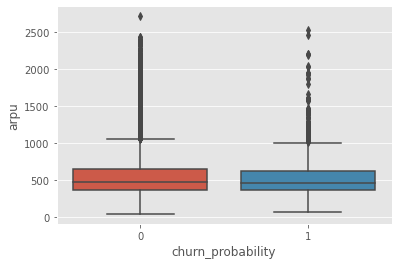

In [617]:
sns.boxplot(data=data_hvc, x="churn_probability", y="arpu")

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_8'>

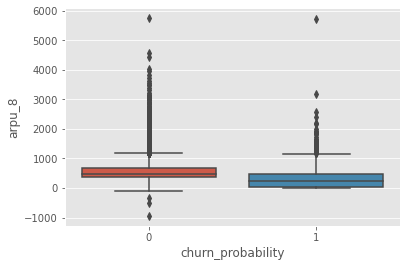

In [618]:
sns.boxplot(data=data_hvc, x="churn_probability", y="arpu_8")

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_7'>

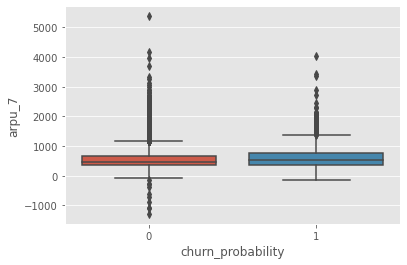

In [619]:
sns.boxplot(data=data_hvc, x="churn_probability", y="arpu_7")

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_6'>

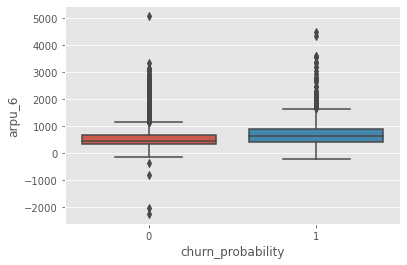

In [620]:
sns.boxplot(data=data_hvc, x="churn_probability", y="arpu_6")

Similarly if the revenue of the customer is descreasing month over month, she/he is likely to churn

##### Target variable with data volume consumed

<AxesSubplot:xlabel='churn_probability', ylabel='total_vol_2g_3g'>

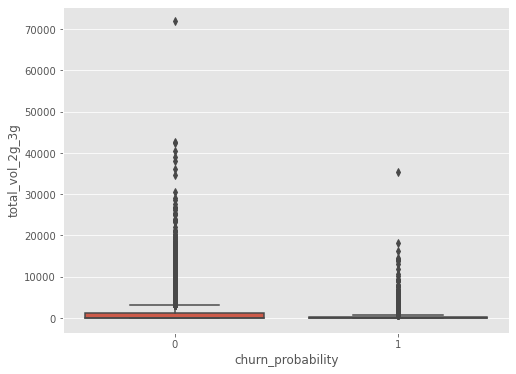

In [621]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_hvc, x="churn_probability", y="total_vol_2g_3g")

Trend is low data consumption customers are likely to churn

##### Churn vs last recharge

<AxesSubplot:xlabel='churn_probability', ylabel='date_of_last_rech_8'>

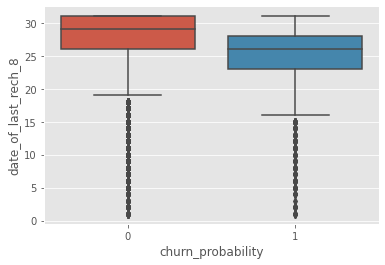

In [622]:
sns.boxplot(data=data_hvc, x="churn_probability", y="date_of_last_rech_8")

Not a significance difference, but if a customer has not recharged lately, then she/he is likely to churn

##### Target and age on network

<AxesSubplot:xlabel='churn_probability', ylabel='aon'>

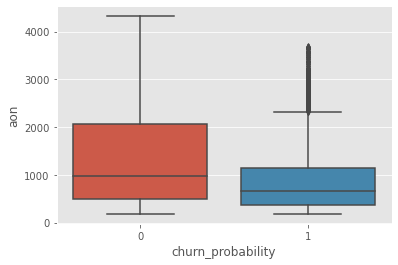

In [623]:
sns.boxplot(data=data_hvc, x="churn_probability", y="aon")

Here we can see if user age on the network is more, he/she is less likely to churn

##### Churn vs min usages

<AxesSubplot:xlabel='churn_probability', ylabel='total_mou'>

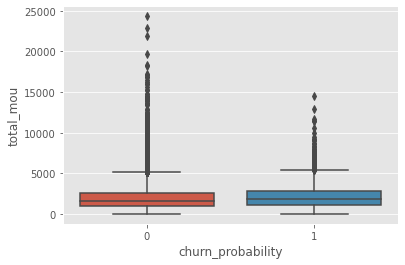

In [624]:
sns.boxplot(data=data_hvc, x="churn_probability", y="total_mou")

We can see much difference, let see in details month wise

<AxesSubplot:xlabel='churn_probability'>

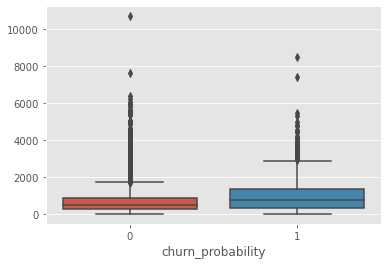

In [625]:
sns.boxplot(data=data_hvc, x="churn_probability", y=data["onnet_mou_6"] + data["offnet_mou_6"])

<AxesSubplot:xlabel='churn_probability'>

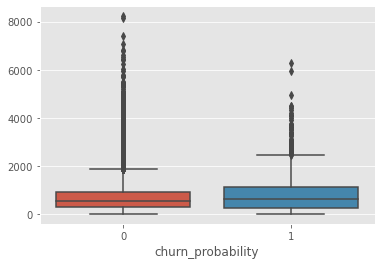

In [626]:
sns.boxplot(data=data_hvc, x="churn_probability", y=data["onnet_mou_7"] + data["offnet_mou_7"])

<AxesSubplot:xlabel='churn_probability'>

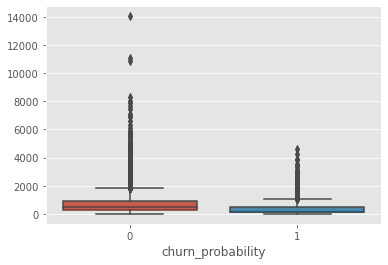

In [627]:
sns.boxplot(data=data_hvc, x="churn_probability", y=data["onnet_mou_8"] + data["offnet_mou_8"])

Here we can see that if usage is declining the customer is likely to churn

**Performing EDA gave us following insights**
- If customer is recharging less month on month he/she is likely to churn
- If customer's revenue is decreasing month on month he/she is likely to churn
- Customer consuming less internet data is likely to churn
- If is a customer has not done recharge lately, he/she might end up churning
- Customer who is using the network for long enough is not likely to churn
- If total voice call usage is declining month over month customer will likely churn

## 3. Data preparation

##### Checking for correlation

In [628]:
cor = data_hvc.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

total_og_mou_8    arpu_8              0.600819
total_mou         onnet_mou_6         0.601037
                  arpu                0.601406
total_og_mou_7    std_og_t2t_mou_7    0.601900
roam_og_mou_7     roam_ic_mou_7       0.602516
                                        ...   
total_ic_mou_8    loc_ic_mou_8        0.896368
total_rech_amt_6  arpu_6              0.901162
total_mou         total_og_mou_7      0.907376
total_rech_amt_8  arpu_8              0.912715
total_rech_amt    arpu                0.968591
Length: 203, dtype: float64

There are quiet a few number of correlated features but we'll not remove those, as we'll go ahead and do PCA

In [629]:
data_hvc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21875 entries, 12 to 69996
Columns: 130 entries, arpu_6 to total_mou
dtypes: float64(106), int64(24)
memory usage: 22.4 MB


#### Splitting the data

In [630]:
y = data_hvc.pop("churn_probability")
X = data_hvc

In [631]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, 
                                                    random_state=1)

In [632]:
scaler = StandardScaler()

In [633]:
X_train = scaler.fit_transform(X_train)

In [634]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-0.058431,-0.158082,-0.154643,-0.465138,-0.539613,-0.509764,-0.215622,-0.199360,-0.462429,-0.241843,...,-0.309269,-0.319644,1.862621,-0.180356,0.062328,0.267085,-0.154636,-0.201065,-0.120841,-0.650664
1,1.259987,-0.014610,-1.533743,-0.403233,-0.603651,-0.530134,2.965687,1.083385,-0.656103,-0.241843,...,-0.309269,-0.319644,-0.175427,-0.347139,-0.333757,-0.319301,-0.132044,-0.099311,-0.035485,0.473414
2,-1.209046,-0.206100,-0.084510,-0.511617,0.190755,0.480556,-0.845873,-0.732312,-0.733135,-0.228223,...,-0.309269,-0.319644,-0.585080,-0.347139,-0.333757,-0.319301,-0.632147,-0.643339,0.175094,-0.571875
3,-0.871224,-0.414962,-0.656792,-0.571022,-0.531485,-0.539192,-0.526772,-0.270225,-0.534992,-0.241843,...,-0.309269,-0.319644,2.344805,-0.347139,-0.333757,-0.319301,-0.818865,-0.847853,-0.438854,-0.805412
4,1.031673,1.210756,1.340041,-0.614755,-0.575546,-0.590669,-0.830643,-0.878265,-0.849456,-0.241843,...,1.440740,1.470551,-0.820043,-0.347139,-0.333757,-0.319301,1.499486,1.712099,-0.077693,-1.174979


In [635]:
X_test = scaler.transform(X_test)

In [636]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.095678,-0.382712,-1.532775,2.514655,1.482175,-0.598387,-0.721296,-0.799973,-0.847072,-0.241843,...,-0.309269,-0.319644,-0.540130,-0.347139,-0.333757,-0.319301,-0.773069,-0.825689,-0.438854,0.267077
1,-0.466430,-0.227806,-0.537686,-0.059351,0.745840,0.481300,-0.782349,-0.840158,-0.780351,-0.241843,...,-0.309269,-0.319644,1.055574,-0.347139,-0.333757,-0.319301,-0.520865,-0.543601,0.245845,-0.324897
2,-0.897112,-0.647491,-0.510134,-0.600044,-0.539741,-0.490606,-0.684750,-0.630355,-0.575527,-0.241843,...,-0.309269,1.470551,-0.363397,2.049926,0.879426,0.608574,-0.859533,-0.786398,0.677903,-0.952520
3,-0.262279,-1.111283,-0.147834,-0.501415,-0.577642,-0.370641,1.057616,-0.273191,0.592515,-0.241843,...,-0.309269,-0.319644,-0.321513,-0.347139,-0.333757,-0.319301,-0.619082,-0.741062,-0.438854,-0.028589
4,1.426925,1.258297,3.623259,0.678420,0.511759,2.249437,0.522763,0.153105,0.557973,-0.241843,...,-0.309269,-0.319644,0.723561,-0.347139,-0.333757,-0.319301,2.670622,2.697393,-0.438854,1.275869


#### PCA

In [637]:
pca = PCA(random_state=100)
X_train_pca = pca.fit_transform(X_train)

In [638]:
columns = [f"PCA{i}" for i in range(1, len(X_train_pca[0]) + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=columns)
X_train_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA120,PCA121,PCA122,PCA123,PCA124,PCA125,PCA126,PCA127,PCA128,PCA129
0,3.426103,-8.249539,-4.720526,0.950689,-1.975023,-2.210792,-0.397878,-3.837513,-2.761254,2.856501,...,3.931680e-06,-9.791673e-07,-1.115991e-07,8.095320e-07,7.443599e-15,-3.372369e-16,3.834780e-16,3.711999e-15,2.317358e-17,1.422751e-15
1,-0.465703,3.181626,0.286652,0.982287,1.042348,-1.948768,-6.103556,0.706911,0.380573,-1.140678,...,1.659239e-07,2.902159e-06,-6.853323e-06,2.709106e-06,3.837763e-15,6.499409e-16,1.542642e-15,2.735814e-15,-2.657537e-16,9.559948e-15
2,-3.438247,1.914164,-0.625840,-0.373354,-2.989159,-1.593822,2.188687,0.398626,2.208342,0.352647,...,-2.078953e-06,-3.907014e-06,-1.020517e-05,-1.744336e-06,-4.827319e-15,-1.409860e-15,-5.531084e-16,-1.496300e-15,-1.095787e-16,-1.540495e-15
3,-2.871762,-1.898524,-1.507430,-0.323274,1.379066,0.583661,-0.056529,-0.496332,-1.018494,-0.095650,...,-1.206917e-06,-3.330586e-06,2.242227e-07,-5.461739e-08,-3.602061e-15,-1.597304e-15,-9.328941e-16,-3.754672e-15,7.935468e-16,-1.739862e-16
4,-0.819418,-1.231664,5.884516,-1.161627,4.115713,2.435092,2.680045,-0.840560,0.409372,0.480282,...,-7.438368e-06,-8.043575e-06,-2.642214e-07,8.699999e-07,-5.597868e-16,1.582735e-15,4.420584e-16,-6.477279e-16,4.467162e-16,2.466995e-16


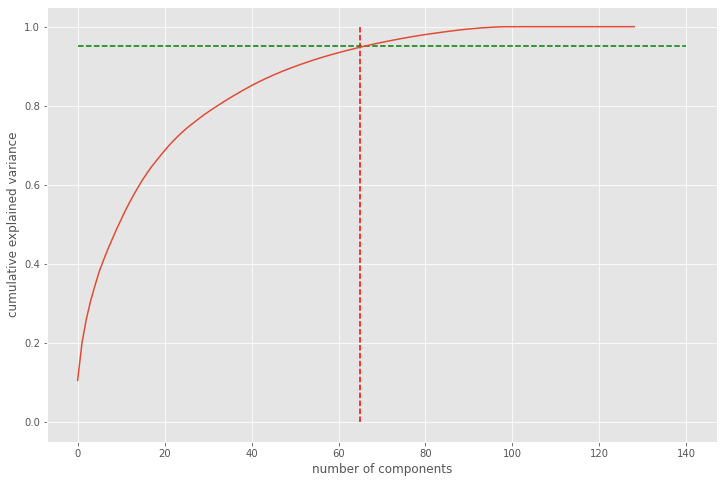

In [639]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=65, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=140, xmin=0, colors="g", linestyles="--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We can see that 65 components are able to explain more than 95% of the variance. So lets select the number of components as 65 and create a new dataset

In [640]:
pca = PCA(n_components=65, random_state=100)
X_train_pca = pca.fit_transform(X_train)

In [641]:
columns = [f"PCA{i}" for i in range(1, len(X_train_pca[0]) + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=columns)
X_train_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65
0,3.426103,-8.249539,-4.720526,0.950689,-1.975020,-2.210788,-0.397889,-3.837530,-2.761253,2.856493,...,-0.636243,0.341181,-0.019867,0.138207,-0.142678,-0.034074,0.078559,-0.449894,0.829129,0.155415
1,-0.465703,3.181626,0.286652,0.982287,1.042348,-1.948762,-6.103575,0.706916,0.380574,-1.140693,...,-0.385021,-0.302351,0.583370,-0.233370,0.795359,0.318370,-0.998743,0.425611,-0.437976,1.852505
2,-3.438247,1.914164,-0.625841,-0.373354,-2.989159,-1.593826,2.188689,0.398650,2.208336,0.352627,...,1.368399,0.311684,-1.125406,0.288706,0.086486,0.122041,-0.221827,0.056700,-0.220539,0.178296
3,-2.871762,-1.898524,-1.507430,-0.323274,1.379067,0.583662,-0.056534,-0.496336,-1.018486,-0.095654,...,-0.107370,-0.128652,-0.453915,0.142578,0.382140,0.032617,-1.014076,-0.011004,-0.130945,-0.125111
4,-0.819418,-1.231664,5.884516,-1.161627,4.115711,2.435087,2.680062,-0.840560,0.409371,0.480291,...,0.729841,0.526877,-1.294147,0.218608,-0.288109,0.151788,0.065763,0.181824,-0.011631,-0.401000


In [642]:
X_test_pca = pca.transform(X_test)

In [643]:
columns = [f"PCA{i}" for i in range(1, len(X_test_pca[0]) + 1)]
X_test_pca = pd.DataFrame(X_test_pca, columns=columns)
X_test_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65
0,-2.740693,3.380675,-0.796932,-0.695442,-0.375357,3.371133,-3.282424,-0.820578,-0.441960,0.557788,...,0.553179,0.168220,-0.313472,-0.252312,0.015097,0.154265,0.185699,-0.368031,-0.121316,0.153142
1,-2.968417,1.875541,-0.175128,-0.510554,-2.849216,-0.455028,0.723943,0.865624,2.333779,0.204836,...,-0.479823,0.360584,0.206787,-0.018448,-0.043797,-0.190191,0.012678,0.391009,-0.239373,0.635179
2,-2.806953,-2.909165,1.234765,0.126021,-0.130717,0.287072,0.195393,-2.028417,0.138470,-0.331885,...,-0.476935,-0.540586,-0.046394,-0.730437,-0.771336,0.059157,-0.001476,0.640058,-0.278461,-0.491632
3,-1.942880,1.863733,-0.337668,3.443179,1.953110,0.071652,-0.807314,0.768199,-0.962023,-1.891976,...,-0.066341,-0.983302,0.310961,0.480883,-0.634384,-0.561257,0.344845,-0.479902,-0.561792,0.363673
4,10.355231,-4.623262,-2.760825,-3.394866,-0.299590,1.220280,2.898188,1.270673,1.302121,-0.033614,...,1.473472,1.268042,-0.556000,-1.888830,0.914952,0.373334,-0.258946,1.026983,0.726639,-0.380228


## 4. Modelling and evaluation

Let's applying LogisticRegression, DecisionTree and RandomForest to see which one gives the highest accuracy

#### Logistic Regression

In [644]:
logistic_pca = LogisticRegression()

In [645]:
model_pca = logistic_pca.fit(X_train_pca, y_train)

In [646]:
pred_probs_train = model_pca.predict_proba(X_train_pca)
pred_train = model_pca.predict(X_train_pca)

In [647]:
print("Logistic Regression, train metric")
print("Accuracy: ", round(metrics.accuracy_score(y_train, pred_train), 5))
print("ROC: ", round(metrics.roc_auc_score(y_train, pred_probs_train[:,1]), 5))

Logistic Regression, train metric
Accuracy:  0.93665
ROC:  0.88199


In [648]:
pred_probs_test = model_pca.predict_proba(X_test_pca)
pred_test = model_pca.predict(X_test_pca)

In [649]:
print("Logistic Regression, test metric")
print("Accuracy: ", round(metrics.accuracy_score(y_test, pred_test), 5))
print("ROC: ", round(metrics.roc_auc_score(y_test, pred_probs_test[:,1]), 5))

Logistic Regression, test metric
Accuracy:  0.94301
ROC:  0.87696


#### Decision tree

Lets do Cross Validation to do hyperparameter tuning

In [650]:
dt = DecisionTreeClassifier(random_state=100)

In [651]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [652]:
grid_search.fit(X_train_pca, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [653]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=50,
                       random_state=100)

In [654]:
dt_best = grid_search.best_estimator_

In [655]:
pred_probs_train = dt_best.predict_proba(X_train_pca)
pred_train = dt_best.predict(X_train_pca)

In [656]:
print("Decision tree, train metric")
print("Accuracy: ", round(metrics.accuracy_score(y_train, pred_train), 5))
print("ROC: ", round(metrics.roc_auc_score(y_train, pred_probs_train[:,1]), 5))

Decision tree, train metric
Accuracy:  0.9377
ROC:  0.86421


In [657]:
pred_probs_test = dt_best.predict_proba(X_test_pca)
pred_test = dt_best.predict(X_test_pca)

In [658]:
print("Decision tree, test metric")
print("Accuracy: ", round(metrics.accuracy_score(y_test, pred_test), 5))
print("ROC: ", round(metrics.roc_auc_score(y_test, pred_probs_test[:,1]), 5))

Decision tree, test metric
Accuracy:  0.93783
ROC:  0.82302


#### Random Forest

In [659]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1)

In [660]:
params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [661]:
grid_search.fit(X_train_pca, y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [662]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_estimators=25,
                       n_jobs=-1, random_state=100)

In [663]:
rf_best = grid_search.best_estimator_

In [664]:
pred_probs_train = rf_best.predict_proba(X_train_pca)
pred_train = rf_best.predict(X_train_pca)

In [665]:
print("Decision tree, train metric")
print("Accuracy: ", round(metrics.accuracy_score(y_train, pred_train), 5))
print("ROC: ", round(metrics.roc_auc_score(y_train, pred_probs_train[:,1]), 5))

Decision tree, train metric
Accuracy:  0.9646
ROC:  0.99667


In [666]:
pred_probs_test = rf_best.predict_proba(X_test_pca)
pred_test = rf_best.predict(X_test_pca)

In [667]:
print("Decision tree, test metric")
print("Accuracy: ", round(metrics.accuracy_score(y_test, pred_test), 5))
print("ROC: ", round(metrics.roc_auc_score(y_test, pred_probs_test[:,1]), 5))

Decision tree, test metric
Accuracy:  0.94164
ROC:  0.85221


## Testing with test data

In [668]:
df_test = pd.read_csv("test (1).csv")

#### Applying transformations

In [669]:
df_test.dropna(thresh=len(df_test.index) * 0.7, axis=1, inplace=True)

In [670]:
df_test.drop(redundant_cols, axis=1, inplace=True)

In [671]:
df_test.drop("id", axis=1, inplace=True)

In [672]:
df_test['date_of_last_rech_6'] = pd.to_datetime(df_test['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [673]:
df_test['date_of_last_rech_7'] = pd.to_datetime(df_test['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [674]:
df_test['date_of_last_rech_8'] = pd.to_datetime(df_test['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [675]:
df_test.fillna(df_test.median(), inplace=True)

In [676]:
df_test["arpu"] = (df_test["arpu_6"] + df_test["arpu_7"] + df_test["arpu_8"] ) / 3

In [677]:
df_test["total_rech_amt"] = df_test["total_rech_amt_6"] + df_test["total_rech_amt_7"] + df_test["total_rech_amt_8"]

In [678]:
df_test["total_vol_2g_3g"] = df_test["vol_2g_mb_6"] + df_test["vol_2g_mb_7"] + df_test["vol_2g_mb_8"] + df_test["vol_3g_mb_6"] + df_test["vol_3g_mb_7"] + df_test["vol_3g_mb_8"]

In [679]:
df_test["total_mou"] = df_test["onnet_mou_6"] + df_test["onnet_mou_7"] + df_test["onnet_mou_8"] + df_test["offnet_mou_6"] + df_test["offnet_mou_7"] + df_test["offnet_mou_8"]

In [681]:
X_test = scaler.transform(df_test)

In [682]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-1.282692,-1.493885,-1.355596,-0.549926,-0.590326,-0.549249,-0.753822,-0.828726,-0.778482,-0.241843,...,-0.309269,-0.319644,0.415045,-0.347139,-0.333757,-0.319301,-1.725893,-1.711245,-0.438854,-1.097322
1,-0.378156,-0.150890,-0.536190,-0.452302,-0.545452,-0.556202,0.176527,0.448021,-0.004921,-0.241843,...,-0.309269,-0.319644,1.274192,-0.347139,-0.333757,-0.319301,-0.452009,-0.454944,-0.438854,-0.257020
2,-0.614822,-0.391559,0.529096,-0.604040,-0.616784,-0.580527,-0.850815,-0.799172,-0.756550,0.111203,...,-0.309269,-0.319644,-1.030488,1.036432,1.583737,0.341702,-0.189398,0.552514,-0.438854,-1.138966
3,-1.418342,-1.177523,-1.466293,-0.609018,-0.628976,-0.598387,-0.799016,-0.454480,-0.801725,-0.241843,...,-0.309269,-0.319644,-0.042622,-0.347139,-0.333757,-0.319301,-1.704820,-1.593372,-0.438854,-1.053545
4,-0.679346,-0.476854,-0.391171,0.385794,0.669054,0.891461,-0.752070,-0.846740,-0.693996,-0.241843,...,-0.309269,-0.319644,-0.841496,-0.347139,-0.333757,-0.319301,-0.647608,-0.563750,-0.438854,-0.084941


In [683]:
X_test_pca = pca.transform(X_test)

In [684]:
columns = [f"PCA{i}" for i in range(1, len(X_test_pca[0]) + 1)]
X_test_pca = pd.DataFrame(X_test_pca, columns=columns)
X_test_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65
0,-6.117301,0.096059,-1.748336,-0.128523,0.512836,0.479056,-0.002528,0.070724,-0.729042,-0.682200,...,-0.108551,-0.060748,-0.139370,0.007262,-0.103984,-0.088830,0.174203,-0.021624,0.031148,0.056365
1,-1.029126,-1.968757,-1.091574,-0.964526,2.465375,0.524351,-0.320329,0.869061,-0.186209,-0.683796,...,-0.239682,-0.403220,0.456746,0.269657,0.318130,-0.186070,0.092239,0.238744,0.091209,-0.037577
2,-3.549355,0.108727,2.146550,-0.411224,0.986519,0.581846,0.826231,0.740865,-0.379695,1.429981,...,-0.104001,0.115322,1.938317,0.036706,0.198612,-0.021614,0.263477,0.038301,-0.192285,-0.031723
3,-3.650705,-2.634868,-2.928457,0.809389,-0.009043,-0.284479,-0.331561,-1.556828,-1.564105,0.446631,...,0.033566,-0.014754,-0.005044,-0.072133,-0.078350,0.050792,0.036035,0.173955,0.031551,-0.125479
4,-2.410392,2.833029,-0.505857,1.053573,-0.735225,2.263862,0.738570,-0.652513,-0.365524,-0.289167,...,-0.022112,-0.210386,-0.227381,-0.058479,0.101608,0.233185,0.228558,-0.207001,-0.017827,-0.117230


In [697]:
pred_probs_test = rf_best.predict_proba(X_test_pca)
pred_test = rf_best.predict(X_test_pca)

In [698]:
df_final = pd.read_csv("solution (1).csv")

In [699]:
df_final.drop("churn_probability", axis=1, inplace=True)

In [700]:
df_final["churn_probability"] = pred_test

In [701]:
df_final.to_csv("Solution_2.csv", index=False)

In [702]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 30000 non-null  int64
 1   churn_probability  30000 non-null  int64
dtypes: int64(2)
memory usage: 468.9 KB


In [703]:
pred_probs_test = dt_best.predict_proba(X_test_pca)
pred_test = dt_best.predict(X_test_pca)

In [704]:
df_final = pd.read_csv("solution (1).csv")

In [705]:
df_final.drop("churn_probability", axis=1, inplace=True)

In [706]:
df_final["churn_probability"] = pred_test

In [707]:
df_final.to_csv("Solution_3.csv", index=False)

In [708]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 30000 non-null  int64
 1   churn_probability  30000 non-null  int64
dtypes: int64(2)
memory usage: 468.9 KB
